# Amazon Clothing Recommendation Engine

### Import necessary packages.


In [249]:
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [250]:
from pprint import pprint

### Load Original Data

In [251]:
data = pd.read_json('/ilab/users/ak1648/akshat/women_clothing_amazon.json')

We will be using the following features
    1. asin  ( Amazon standard identification number)
    2. brand ( brand to which the product belongs to )
    3. color ( Color information of apparel, it can contain many colors as   a value ex: red and black stripes ) 
    4. product_type_name (type of the apperal, ex: SHIRT/TSHIRT )
    5. medium_image_url  ( url of the image )
    6. title (title of the product.)
    7. formatted_price (price of the product)

In [252]:
data = data[['asin', 'brand', 'color', 'medium_image_url', 'product_type_name', 'title', 'formatted_price']]
print ('Number of data points : ', data.shape[0], \
       'Number of features:', data.shape[1])
data.head()

Number of data points :  183138 Number of features: 7


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
0,B016I2TS4W,FNC7C,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Minions Como Superheroes Ironman Long Sleeve R...,None
1,B01N49AI08,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Izo Tunic,None
2,B01JDPCOHO,FIG Clothing,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,FIG Clothing Womens Won Top,None
3,B01N19U5H5,Focal18,None,https://images-na.ssl-images-amazon.com/images...,SHIRT,Focal18 Sailor Collar Bubble Sleeve Blouse Shi...,None
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,Featherlite Ladies' Long Sleeve Stain Resistan...,$26.26


In [253]:
data = pd.read_pickle('/ilab/users/ak1648/akshat/180k_apparel_data')

# Data Preprocessing

### Removing Null Values

In [254]:
data = data.loc[~data['formatted_price'].isnull()]
print('Number of products fter eliminating NULL price :', data.shape[0])

data =data.loc[~data['color'].isnull()]
print('Number of data points After eliminating NULL color :', data.shape[0])

Number of products fter eliminating NULL price : 28395
Number of data points After eliminating NULL color : 28385


### Removing the products with short description

In [255]:
data_sorted = data[data['title'].apply(lambda x: len(x.split())>4)]
print("After removal of products with short description:", data_sorted.shape[0])

After removal of products with short description: 27949


### Removing the products with duplicate title

In [256]:
data = pd.read_pickle('/ilab/users/ak1648/akshat/28k_apparel_data')
print('The number of entries with duplicate title is %d'%sum(data.duplicated('title')))
# Sort the whole data based on title
data_sorted.sort_values('title',inplace=True, ascending=False)

indices = []
for i,row in data_sorted.iterrows():
    indices.append(i)
import itertools
stage1_dedupe_asins = []
i = 0
j = 0
num_data_points = data_sorted.shape[0]
while i < num_data_points and j < num_data_points:    
    previous_i = i
    a = data['title'].loc[indices[i]].split()
    j = i+1
    while j < num_data_points:
        b = data['title'].loc[indices[j]].split()
        length = max(len(a), len(b))
        count  = 0
        for k in itertools.zip_longest(a,b): 
            if (k[0] == k[1]):
                count += 1
        # Ignore the products if the number of words in which both strings differ are < 2
        if (length - count) > 2: # number of words in which both sensences differ
            stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[i]])
            if j == num_data_points-1: stage1_dedupe_asins.append(data_sorted['asin'].loc[indices[j]])
            i = j
            break
        else:
            j += 1
    if previous_i == i:
        break

data = data.loc[data['asin'].isin(stage1_dedupe_asins)]
print('Number of data points now is: ', data.shape[0])

The number of entries with duplicate title is 2325
Number of data points now is:  17593


# Text Preprocessing

In [257]:
data = pd.read_pickle('/ilab/users/ak1648/akshat/16k_apperal_data')

In [258]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /ilab/users/ak1648/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [259]:
# we use the list of stop words that are downloaded from nltk lib.
stop_words = set(stopwords.words('english'))
print ('list of stop words:', stop_words)

def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        for words in total_text.split():
            # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
            word = ("".join(e for e in words if e.isalnum()))
            # Conver all letters to lower-case
            word = word.lower()
            # stop-word removal
            if not word in stop_words:
                string += word + " "
        data[column][index] = string

list of stop words: {'hers', 'but', 'not', 'above', "wasn't", 'or', 'o', 'most', 'yours', 'he', 'some', 'again', 'be', "doesn't", 'on', "you're", 'below', 'why', 't', 'weren', 'because', 'being', 'any', 'for', 'ain', 'what', 'shan', "mustn't", "should've", 'mightn', "aren't", 'of', 'very', 'than', 'ma', "wouldn't", 'over', 'it', 'up', 'did', "haven't", 'have', 'didn', 'haven', 'against', 'had', 'wasn', 'his', "won't", 'its', 'yourself', 'before', 'will', 'then', 'they', 'so', 've', 'whom', 'from', "mightn't", "you'll", 'm', 'couldn', 'the', 'only', 'been', 'between', 'itself', 'this', 'ours', 'was', "it's", 'more', 'who', 'is', 'there', 'few', 'too', 'until', 'theirs', 'y', 'should', 'all', 'through', 'both', 's', 'after', 'were', 'and', 'with', 'doesn', 'in', 'themselves', 'once', 'are', 'other', 'if', "that'll", 'him', 'when', 'nor', 'no', "don't", 'can', 'needn', "weren't", 'i', "she's", 'me', 'those', 'hadn', 'off', 'how', 'under', 'you', 'at', 'into', "couldn't", "you'd", 'your', 

In [260]:
start_time = time.clock()
# we take each title and we text-preprocess it.
for index, row in data.iterrows():
    nlp_preprocessing(row['title'], index, 'title')
# we print the time it took to preprocess whole titles 
print(time.clock() - start_time, "seconds")

data.head()

9.900000000000034 seconds


,asin,brand,color,medium_image_url,product_type_name,title,formatted_price
4,B004GSI2OS,FeatherLite,Onyx Black/ Stone,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies long sleeve stain resistant...,$26.26
6,B012YX2ZPI,HX-Kingdom Fashion T-shirts,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens unique 100 cotton special olympics wor...,$9.99
15,B003BSRPB0,FeatherLite,White,https://images-na.ssl-images-amazon.com/images...,SHIRT,featherlite ladies moisture free mesh sport sh...,$20.54
27,B014ICEJ1Q,FNC7C,Purple,https://images-na.ssl-images-amazon.com/images...,SHIRT,supernatural chibis sam dean castiel neck tshi...,$7.39
46,B01NACPBG2,Fifth Degree,Black,https://images-na.ssl-images-amazon.com/images...,SHIRT,fifth degree womens gold foil graphic tees jun...,$6.95


### Utility Functions

In [261]:
#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)

#plotting code to understand the decision  
def plot_image(keys, values, labels, url, text):
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # plotting image of the the apparel
        ax = plt.subplot(gs[0])
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        display_img(url, ax, fig)
        
        plt.show()
    
def plot_condition(doc_id, vec1, vec2, url, text, model):
    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, Bag of Words or TF-IDF
    intersection = set(vec1.keys()) & set(vec2.keys()) 
    for i in vec2:
        if i not in intersection:
            vec2[i]=0
    keys = list(vec2.keys())
    values = [vec2[x] for x in vec2.keys()]    
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    plot_image(keys, values, labels, url, text)

# this function gets a list of wrods along with the frequency of each word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    return Counter(words)

def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b    
    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)
    plot_condition(doc_id, vector1, vector2, url, text2, model)

# Textual Recommendation based on Product Titles

## Bag of Words model on Product Titles

In [262]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
bag_of_words_euclidean=[]
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # cosine distance for similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    # pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # Pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print ('Title:', data['title'].loc[df_indices[i]])
        bag_of_words_euclidean.append(pdists[i])
        print ('Euclidean similarity with the input image :', pdists[i])
    print('Average euclidean distance is ',sum(bag_of_words_euclidean)/num_results)

## Top 10 Recommendation using Bag of Words Model

First one is input image and the rest 10 are recommended clothing


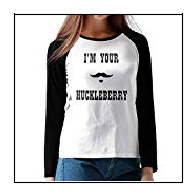

Title: im huckleberry doc holliday 34sleeve raglan long sleeve 
Euclidean similarity with the input image : 0.0


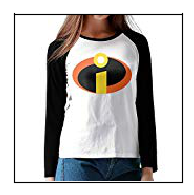

Title: incredibles 34sleeve raglan long sleeve 
Euclidean similarity with the input image : 2.23606797749979


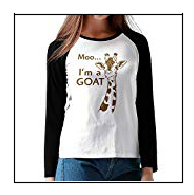

Title: moo im goat 34sleeve raglan long sleeve 
Euclidean similarity with the input image : 2.23606797749979


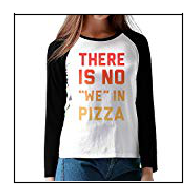

Title: pizza 34sleeve raglan long sleeve 
Euclidean similarity with the input image : 2.23606797749979


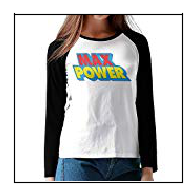

Title: maxpower 34sleeve raglan long sleeve 
Euclidean similarity with the input image : 2.23606797749979


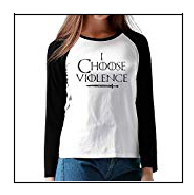

Title: choose violence 34sleeve raglan long sleeve 
Euclidean similarity with the input image : 2.449489742783178


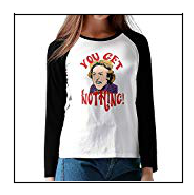

Title: get nothing 34sleeve raglan long sleeve 
Euclidean similarity with the input image : 2.449489742783178


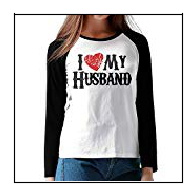

Title: love husband 34sleeve raglan long sleeve 
Euclidean similarity with the input image : 2.449489742783178


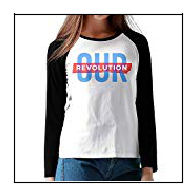

Title: revolution logo 34sleeve raglan long sleeve 
Euclidean similarity with the input image : 2.449489742783178


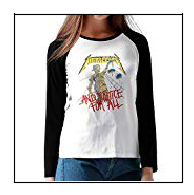

Title: metallica justice 34sleeve raglan long sleeve 
Euclidean similarity with the input image : 2.449489742783178
Average euclidean distance is  2.119172062391505


In [263]:
print('First one is input image and the rest 10 are recommended clothing')
bag_of_words_model(12562, 10)

## TF-IDF Model on Product Titles

In [264]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])
tf_idf_euclidean=[]
def tfidf_model(doc_id, num_results):
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]],data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print ('Title:', data['title'].loc[df_indices[i]])
        tf_idf_euclidean.append(pdists[i])
        print ('Eucliden distance from the given image :', pdists[i])
    print('Average euclidean distance is',sum(tf_idf_euclidean)/num_results)


## Top 10 Recommendations using TF-IDF Model

First one is input image and the rest 10 are recommended clothing


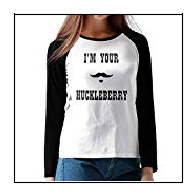

Title: im huckleberry doc holliday 34sleeve raglan long sleeve 
Eucliden distance from the given image : 0.0


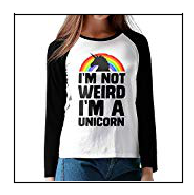

Title: im weird im unicorn 34sleeve raglan long sleeve 
Eucliden distance from the given image : 1.0649487461630645


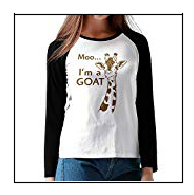

Title: moo im goat 34sleeve raglan long sleeve 
Eucliden distance from the given image : 1.133575440305773


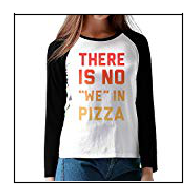

Title: pizza 34sleeve raglan long sleeve 
Eucliden distance from the given image : 1.1627003249587693


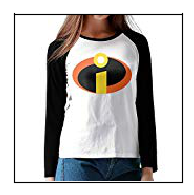

Title: incredibles 34sleeve raglan long sleeve 
Eucliden distance from the given image : 1.1872291620915076


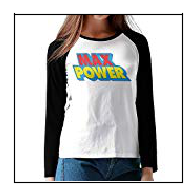

Title: maxpower 34sleeve raglan long sleeve 
Eucliden distance from the given image : 1.1872291620915076


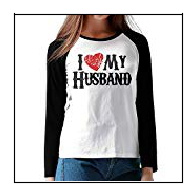

Title: love husband 34sleeve raglan long sleeve 
Eucliden distance from the given image : 1.1960847619438466


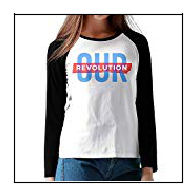

Title: revolution logo 34sleeve raglan long sleeve 
Eucliden distance from the given image : 1.2023792573811647


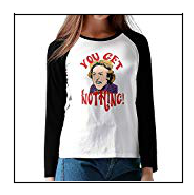

Title: get nothing 34sleeve raglan long sleeve 
Eucliden distance from the given image : 1.2117794081962616


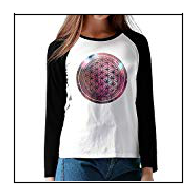

Title: flower life galaxy 34sleeve raglan long sleeve 
Eucliden distance from the given image : 1.21205545761381
Average euclidean distance is 1.0557981720745704


In [265]:
print('First one is input image and the rest 10 are recommended clothing')
tfidf_model(12562, 10)

# Visual Recommendation based on Product Images

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import requests
from PIL import Image
import pandas as pd
import pickle

## Feature Extraction from Product Images using VGG16 CNN

In [ ]:
# each image is converted into 25088 length dense-vector

# dimensions of our images.
img_width, img_height = 224, 224

top_model_weights_path = '/ilab/users/ak1648/akshat/images/bottleneck_fc_model.h5'
train_data_dir = '/ilab/users/ak1648/akshat/images/'
nb_train_samples = 16042
epochs = 50
batch_size = 1


def save_bottlebeck_features():
    
    #Function to compute VGG-16 CNN for image feature extraction.
    
    asins = []
    datagen = ImageDataGenerator(rescale=1. / 255)
    
    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')
    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

    for i in generator.filenames:
        asins.append(i[2:-5])

    bottleneck_features_train = model.predict_generator(generator, nb_train_samples // batch_size)
    bottleneck_features_train = bottleneck_features_train.reshape((16042,25088))
    
    np.save(open('/ilab/users/ak1648/akshat/16k_data_cnn_features.npy', 'wb'), bottleneck_features_train)
    np.save(open('/ilab/users/ak1648/akshat/16k_data_cnn_feature_asins.npy', 'wb'), np.array(asins))
    

save_bottlebeck_features()

## VGG16 CNN model on Product Images

In [267]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('/ilab/users/ak1648/akshat/16k_data_cnn_features.npy')
asins = np.load('/ilab/users/ak1648/akshat/16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('/ilab/users/ak1648/akshat/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])


from IPython.display import display, Image, SVG, Math, YouTubeVideo

cnn_euclidean=[]
#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            cnn_euclidean.append(pdists[i])
            print('Euclidean Distance from input image:', pdists[i])
    print('Average euclidean distance is ',sum(cnn_euclidean)/num_results)

## Top 10 Recommendations using VGG16 CNN Model

First one is input image and the rest 10 are recommended clothing


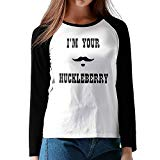

Product Title:  im huckleberry doc holliday 34sleeve raglan long sleeve 
Euclidean Distance from input image: 0.0625


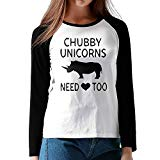

Product Title:  chubby unicorn need love 34sleeve raglan long sleeve 
Euclidean Distance from input image: 17.071169


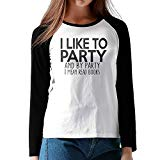

Product Title:  bibliophile literary like party 34sleeve raglan long sleeve 
Euclidean Distance from input image: 18.06369


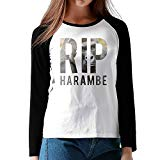

Product Title:  rip harambe cartoon 17th birthday killed 34sleeve raglan long sleeve 
Euclidean Distance from input image: 18.658527


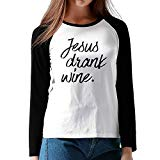

Product Title:  jesus drank wine 34sleeve raglan long sleeve 
Euclidean Distance from input image: 18.854345


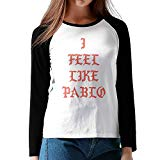

Product Title:  kanye west pinterest 34sleeve raglan long sleeve 
Euclidean Distance from input image: 18.991518


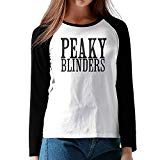

Product Title:  xjbd womens peaky drama series long sleeve blended baseball shirt size xl 
Euclidean Distance from input image: 19.783867


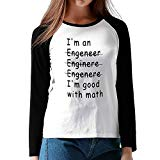

Product Title:  engineer good math 34sleeve raglan long sleeve 
Euclidean Distance from input image: 20.048672


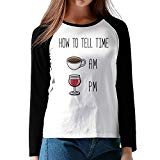

Product Title:  tell time pm 34sleeve raglan long sleeve 
Euclidean Distance from input image: 20.094067


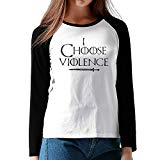

Product Title:  choose violence 34sleeve raglan long sleeve 
Euclidean Distance from input image: 20.477503
Average euclidean distance is  17.21058578491211


In [268]:
print('First one is input image and the rest 10 are recommended clothing')
get_similar_products_cnn(12562, 10)

## Performance Comparison using Eucledian Distance

In [269]:
euclidean_distance=[]
num_results=10
euclidean_distance.append(sum(bag_of_words_euclidean)/num_results)
euclidean_distance.append(sum(tf_idf_euclidean)/num_results)
euclidean_distance.append(sum(cnn_euclidean)/num_results)
x=euclidean_distance

In [270]:
euclidean_distance

[2.119172062391505, 1.0557981720745704, 17.21058578491211]

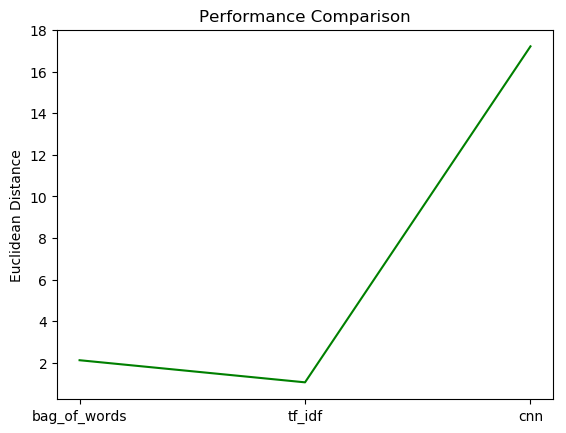

In [280]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
objects = ('bag_of_words', 'tf_idf','cnn')
y_pos = np.arange(len(objects))
plt.plot(y_pos,x,color='green')
plt.xticks(y_pos, objects)
plt.ylabel('Euclidean Distance')
plt.title('Performance Comparison')
 
plt.show()

<BarContainer object of 3 artists>

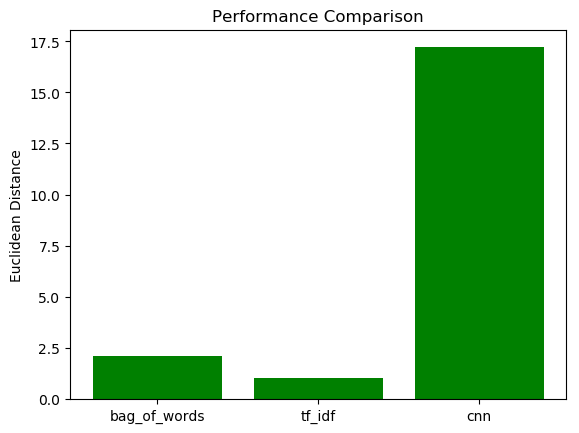

In [281]:
plt.ylabel('Euclidean Distance')
plt.title('Performance Comparison')
plt.bar(objects,x,color = 'green')